In [1]:
# Let's currently use free GPU, which I've found on the server
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import sys; sys.path += ['..', '../src']

Now we gonna reproduce [Unsupervised Neural Machine Translation](https://arxiv.org/abs/1710.11041). What we need for this:
* Implement two decoders for Transformer
* Bring cross lingual embeddings alignment (from https://github.com/facebookresearch/MUSE, for example)
* Currently, we have to use full vocab, because we do not have strong embeddings for BPEs
* Implement corresponding Trainer class

In [3]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok')
train_trg_path = os.path.join(DATA_PATH, 'train.fr.tok')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok')
val_trg_path = os.path.join(DATA_PATH, 'val.fr.tok')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

vocab_src = Vocab.from_sequences(train_src)
vocab_trg = Vocab.from_sequences(train_trg)

# Simple preprocessing: crop lines and remove empty sentences
train_src = [s.split()[:max_len-2] for s in train_src if len(s) != 0]
train_trg = [s.split()[:max_len-2] for s in train_trg if len(s) != 0]
val_src = [s.split()[:max_len-2] for s in val_src if len(s) != 0]
val_trg = [s.split()[:max_len-2] for s in val_trg if len(s) != 0]

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [4]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import SimpleTransformerClassifier

transformer_kwargs = {
    'd_model': 300,
    'd_word_vec': 300
}
# transformer_kwargs = {
#     'n_layers': 2,
#     'n_head': 2,
#     'd_word_vec': 128,
#     'd_model': 128,
#     'd_inner_hid': 256,
#     'd_k': 32,
#     'd_v': 32
# }
transformer = Transformer(len(vocab_src), len(vocab_trg), max_len, **transformer_kwargs)
discriminator = SimpleTransformerClassifier(2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
embeddings_src = load_embeddings('../trained_models/wiki.multi.en.vec')
embeddings_trg = load_embeddings('../trained_models/wiki.multi.fr.vec')

init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

200000it [00:28, 7024.21it/s]
200000it [00:30, 6563.96it/s]


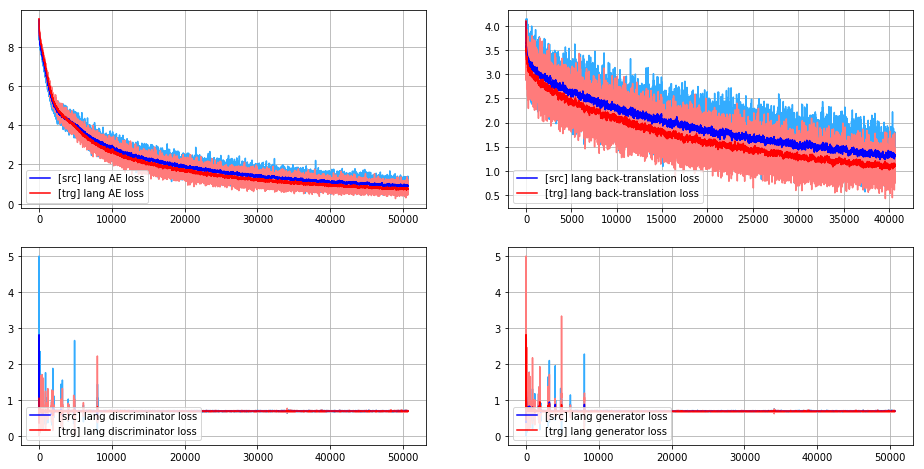

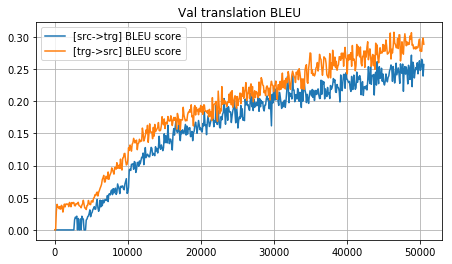

 94%|█████████▍| 1713/1813 [1:05:45<03:50,  2.30s/it]


In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

%matplotlib inline

from src.umt_trainer import UMTTrainer
from src.utils.umt_batcher import UMTBatcher
from src.utils.batcher import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))
adv_criterion = nn.BCEWithLogitsLoss()

# def trainable_params_without_enc_embs(transformer):
#     trainable = transformer.get_trainable_parameters()
#     enc_embs = set(map(id, transformer.encoder.src_word_emb.parameters()))
#     dec_embs = set(map(id, transformer.decoder.tgt_word_emb.parameters()))
#     freezed = enc_embs | dec_embs

#     return (p for p in trainable if not id(p) in freezed)

transformer_optimizer = Adam([
    {'params': transformer.get_trainable_params_without_embs(), 'lr': 1e-4},
    {'params': transformer.get_embs_parameters(), 'lr': 5e-6}
])
# transformer_optimizer = Adam(trainable_params_without_enc_embs(transformer), lr=1e-4)
discriminator_optimizer = Adam(discriminator.trainable_parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab_src,
                           vocab_trg, batch_size=16, shuffle=True)
val_data = Batcher(val_src_idx[:64], val_trg_idx[:64], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=16, shuffle=False)

training_config = {
    'max_num_epochs': 50,
    'start_bt_from_iter': 10000,
    'gen_loss_coef': 0.1
}

trainer = UMTTrainer(transformer, discriminator, vocab_src, vocab_trg,
                  transformer_optimizer, discriminator_optimizer,
                  reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion,
                  training_config)

trainer.run_training(training_data, val_data, plot_every=10, val_bleu_every=100)

In [8]:
val_data = Batcher(val_src_idx, val_trg_idx, vocab_src.token2id,
                   vocab_trg.token2id, batch_size=16, shuffle=False)

scores, translations = trainer.validate_bleu(val_data, return_results=True)

In [9]:
scores

(0.2962679269786486, 0.3159558933011807)

In [13]:
for i in range(5):
    print('Source:             ', translations['targets_trg_to_src'][i])
    print('Translation:        ', translations['translations_src_to_trg'][i])
    print('Target:             ', translations['targets_src_to_trg'][i])
    print('Target translation: ', translations['translations_trg_to_src'][i])
    print()

Source:              A group of men are loading cotton onto a truck
Translation:         Un groupe d'hommes nettoient un camion
Target:              Un groupe d'hommes chargent du coton dans un camion
Target translation:  A group of men are preparing for a truck .

Source:              A man sleeping in a green room on a couch .
Translation:         Un homme accroupi dans une pièce verte sur un canapé .
Target:              Un homme dormant dans une chambre verte sur un canapé .
Target translation:  A man squatting in a green classroom on a cigarette green jacket .

Source:              A boy wearing headphones sits on a woman's shoulders .
Translation:         Un garçon portant des écouteurs regarde une femme .
Target:              Un garçon avec un casque est assis sur les épaules d'une femme .
Target translation:  A boy with a helmet is sitting on the shoulders of a woman .

Source:              Two men setting up a blue ice fishing hut on an iced over lake
Translation:         Deux